<a href="https://colab.research.google.com/github/okana2ki/ML/blob/main/text_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Embeddingを用いた文章の類似度計算とその応用

## 準備

### 日本語で利用可能なtext embeddingモデルの例

以下は、日本語で利用可能なtext embeddingモデルの例です（出典：NLP204チュートリアル, 松田寛）

日本語のモデル：

[SimCSE](https://aclanthology.org/2021.emnlp-main.552/), Gao+ (2021/04)
をベースにしたもの

> [Japanese SimCSE (BERT-base)](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) (2022/12)

> [Japanese Simple-SimCSE](https://github.com/hppRC/simple-simcse-ja?tab=readme-ov-file), Tsukagoshi+ (2023/10)

[ColBERT](https://arxiv.org/abs/2004.12832), Khattab+ (2020/04)
をベースにしたもの

> [JaColBERT](https://huggingface.co/bclavie/JaColBERT), Clavié (2023/12)

多言語モデルの例：

> [multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large), Wang+ (2024/02)


## 日本語のtext embeddingモデルについての追加情報（2025年5月）

- [テキスト埋め込みモデルPLaMo-Embedding-1B](https://a03.hm-f.jp/index.php?action=ViewPublicBnMail&mid=99&gid=15&aid=946&bn_code=847b025ee8c0f2d5466573219aa1245f)

### Japanese SimCSE (BERT-base) モデルのロード

 このノートブックでは、text embeddingモデルとして、[Japanese SimCSE (BERT-base) ](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) を使用します。

 sentence-transformersを使って、このモデルを簡単に利用することができます。トークナイズのために、fugashiとunidic-liteが必要です。まず、下記のように、pipでsentence-transformersとfugashi, unidic-liteをインストールします。

In [ ]:
!pip install -U fugashi[unidic-lite]
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('pkshatech/simcse-ja-bert-base-clcmlp')

### モデルを利用した埋め込み (embedding) 作成例

In [ ]:
sentences = [
    "PKSHA Technologyは機械学習/深層学習技術に関わるアルゴリズムソリューションを展開している。",
    "この深層学習モデルはPKSHA Technologyによって学習され、公開された。",
    "広目天は、仏教における四天王の一尊であり、サンスクリット語の「種々の眼をした者」を名前の由来とする。",
]

embeddings = model.encode(sentences)
print(embeddings)

[[ 0.10946249 -0.00736867  0.29229823 ... -0.3773132  -0.10279876
   0.30691147]
 [ 0.14194755 -0.00458467  0.02018883 ... -0.15762503  0.20828494
   0.4964965 ]
 [-0.01084544 -0.5255608   0.2376968  ... -0.18694653  0.5509592
   0.00368492]]


### 類似度はcosine類似度がお勧め

Japanese SimCSE (BERT-base) モデルは、学習時の損失関数にcosine類似度を使っているため、下流のタスクで**cosine類似度を類似度計算に使うことをおすすめ**します。とのとです。

In [ ]:
# prompt: ネット上のファイル https://github.com/okana2ki/ML/blob/main/2024faculty.csv を読み込み

import pandas as pd

# CSVファイルの読み込み
url = 'https://raw.githubusercontent.com/okana2ki/ML/main/2024faculty.csv'
faculty_df = pd.read_csv(url)
# faculty_df = pd.read_csv(faculty_csv_path, encoding='shift_jis')

# NaNやNoneを含む可能性がある行を削除 <- エラー対策
faculty_df = faculty_df.dropna(subset=['description'])

# description列からsentencesリストを生成
fa_sentences = faculty_df['description'].tolist()

# sentencesの各要素が文字列であることを確認 <- エラー対策
fa_sentences = [str(sentence) for sentence in fa_sentences]

In [ ]:
faculty_df.head()

,id,name,description,pair,similarity
0,0,uchida,プロフィール：\r\n兵庫県出身。宮崎大学大学院農学工学総合研究科物質･情報工学専攻博士後期...,NaN,NaN
1,1,oka,プロフィール：\n出身は徳島で、東京と京都暮らしを経て宮崎に来ました。企業と大学でAI（人工...,NaN,NaN
2,2,okumura,プロフィール：\n宮崎県出身、東京工業大学工学部社会工学科卒業、ハーバード大学大学院公共政策...,NaN,NaN
3,3,kasagi,プロフィール：\n岡山県出身。誠実に生きていくことが信条です。心のなかでは、若いころの情熱と...,NaN,NaN
4,4,kawashima,プロフィール：\n福岡県八女市生まれ。九州大学大学院経済工学の分野で博士の学位を取得。約20...,NaN,NaN


In [ ]:
print(fa_sentences) # 内容確認用

['プロフィール：\r\n兵庫県出身。宮崎大学大学院農学工学総合研究科物質･情報工学専攻博士後期課程修了。兵庫県立但馬技術大学校情報工学科勤務、国立宇部工業高等専門学校経営情報学科勤務などを経て2021年4月より現職。\r\n\r\n担当科目：\r\nアルゴリズム、C言語応用演習\r\n\r\nゼミナールテーマ：\r\n情報教育教材の開発、中小企業向けDXモデルの検討\r\n\r\n学生へのメッセージ：\r\n中学校や高校（中等教育）は、主として「知識」を学ぶところです。大学（高等教育）は、 「勉強のやり方」（問題の解決法）を学ぶところです。別の見方をすると、中等教育は主として「過去」 （もちろん大事です。過去があるからこそ現在があり、さらに未来へとつながっていきます。）に関する勉強であり、高等教育は「未来」（新しい価値の創造）に関する勉強です。本学で、あなたの夢を実現する礎を築いてください。\r\n\r\n関連キーワード：\r\nIT・情報、情報科教員、データサイエンス', 'プロフィール：\n出身は徳島で、東京と京都暮らしを経て宮崎に来ました。企業と大学でAI（人工知能）の研究・教育を続けてきました。赤ちゃんが育つようにAIを育てることや、人と一緒に創造的な活動をするAIを目指しています。生成AI（大規模言語モデル）のしくみを調べて人の知能の秘密を探る研究をしています。\n\n担当科目：\nデータサイエンス入門、多変量解析、実践人工知能、機械学習、データサイエンス演習、情報と職業\n\nゼミナールテーマ：\nデザイン思考により日常生活や地域での課題を発見し、解決策を考え、実現に必要なAI・データサイエンスのスキルを習得し、解決策を実装・実行・評価する、というプロジェクト活動を行います。生成AIを使いこなすことで、誰でもプログラミングできるようになります（そうなることを目指しています）。\n\n学生へのメッセージ：\n皆さんが生きていく時代は、AI技術がさらに急速に発展し、皆さんの生活のすべてがAIと切り離せなくなります。その中で皆さんが大活躍できるように、一緒に最新のAI技術を勉強し、社会の将来像を討議・想像・創造しましょう。\n\nその他(顧問等)：\nITリーダー塾担当：G検定\n\n関連キーワード：\nIT・情報、AI、データサイエンス', 'プロフィール

埋め込みへの変換

In [ ]:
fa_embeddings = model.encode(fa_sentences)

In [ ]:
print(fa_embeddings) # 内容確認用
print(type(fa_sentences)) # debug用
fa_embeddings.shape # debug用

[[ 0.28387588 -0.03769652 -0.07489881 ... -0.36349472  0.22956394
   0.35593322]
 [ 0.22838716  0.14949241 -0.278361   ... -0.46508083  0.03751502
   0.1478704 ]
 [-0.06768743  0.19038533  0.19477797 ... -0.48034388  0.11822381
  -0.38172224]
 ...
 [ 0.22628991 -0.12523201 -0.16998853 ... -0.14100882 -0.00701476
   0.4540785 ]
 [-0.04642363  0.2524227  -0.05341919 ... -0.14016996  0.17206128
  -0.00415981]
 [ 0.47106987 -0.02741148 -0.41398147 ... -0.5642114  -0.27589452
  -0.12221549]]
<class 'list'>


(23, 768)

## コサイン類似度の確認

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 例として、2番目の教員をクエリとして使用し他の教員とのコサイン類似度を計算
# query_embedding = fa_embeddings[0].reshape(1, -1)  # 最初の教員の埋め込みベクトル
query_embedding = fa_embeddings[1].reshape(1, -1)
similarity_scores = cosine_similarity(query_embedding, fa_embeddings).flatten()

# 類似度スコアに基づいて文書のインデックスを降順にソート
sorted_doc_indices = similarity_scores.argsort()[::-1]

# 類似度の降順に名前と類似度スコアを表示
print("全教員を類似度の降順で表示:")
for idx in sorted_doc_indices:
    print(f"{faculty_df['name'].iloc[idx]}: {similarity_scores[idx]:.4f}")

全教員を類似度の降順で表示:
oka: 1.0000
motomura: 0.8594
uchida: 0.8147
kawashima: 0.8091
oouchi: 0.7961
shiraishi: 0.7932
morita: 0.7495
yuhara: 0.7341
nishida: 0.7194
ideyama: 0.7108
yamanashi: 0.6759
hidaka: 0.6732
taketsugu: 0.6728
okumura: 0.6719
tanaka: 0.6703
honda: 0.6692
kasagi: 0.6496
hagihara: 0.6473
miyanaga: 0.6328
miyashita: 0.6324
yasui: 0.6242
sumi: 0.5908
wakamatsu: 0.5144


## コサイン類似度で階層的クラスタリング

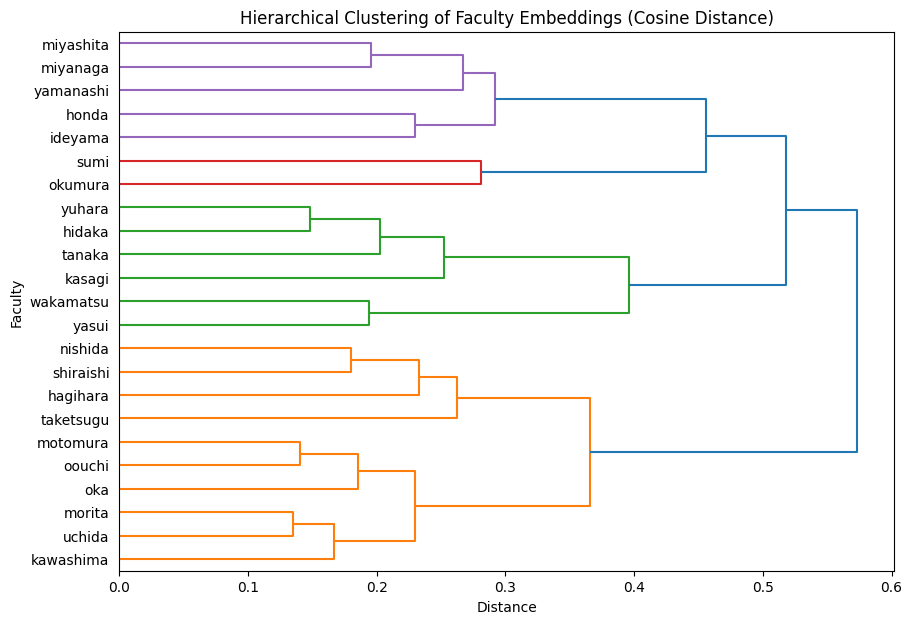

Cluster 1:
  - uchida
  - oka
  - kawashima
  - oouchi
  - motomura
  - morita

Cluster 2:
  - shiraishi
  - taketsugu
  - nishida
  - hagihara

Cluster 3:
  - yasui
  - wakamatsu

Cluster 4:
  - kasagi
  - tanaka
  - hidaka
  - yuhara

Cluster 5:
  - okumura
  - sumi

Cluster 6:
  - miyanaga
  - ideyama
  - honda
  - yamanashi
  - miyashita



In [ ]:
# prompt: ユークリッド距離でなく、コサイン類似度で階層的クラスタリング

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# コサイン距離行列を計算；コサイン距離 = 1 - コサイン類似度；値の範囲は 0 から 2
cosine_distances = pdist(fa_embeddings, metric='cosine')

# 階層的クラスタリングを実行 (ward法を使用)
linkage_matrix = linkage(cosine_distances, method='ward')

# デンドログラムを描画
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=faculty_df['name'].tolist(), orientation='right')
plt.title('Hierarchical Clustering of Faculty Embeddings (Cosine Distance)')
plt.xlabel('Distance')
plt.ylabel('Faculty')
plt.show()

# クラスタ数を指定してクラスタラベルを取得 (例: クラスタ数6)
num_clusters = 6
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタごとに教員名を表示
for cluster_id in range(1, num_clusters + 1):
    print(f"Cluster {cluster_id}:")
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    for idx in cluster_indices:
        print(f"  - {faculty_df['name'].iloc[idx]}")
    print()


## 演習問題１
問い合わせに対して適切な教員を紹介するプログラムを作成しなさい。問い合わせを埋め込みに変換し、コサイン類似度が近い上位5名の教員名を順番を付けて表示して下さい。

## 主成分分析による可視化（参考）

In [ ]:
# prompt: 第20主成分まで主成分分析

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 第20主成分まで主成分分析
pca = PCA(n_components=20)
pca.fit(fa_embeddings)

# 寄与率の確認
print(pca.explained_variance_ratio_)


[0.1525664  0.12767509 0.10288125 0.08193998 0.06897246 0.05705446
 0.05155785 0.04666305 0.04144302 0.03511621 0.030894   0.0307158
 0.02695203 0.0254956  0.02288865 0.0203854  0.01697499 0.01526822
 0.01373148 0.01196255]


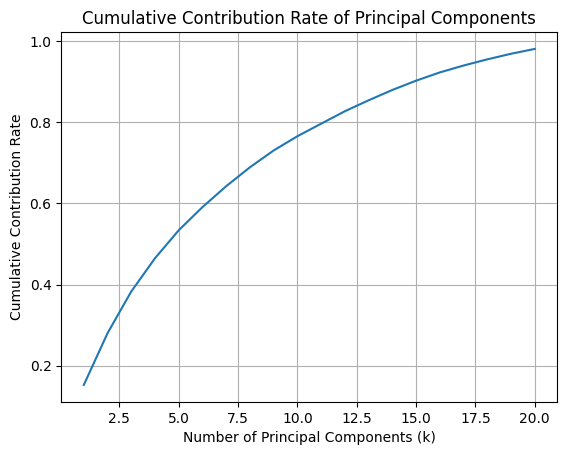

In [ ]:
# prompt: 主成分の数 k を横軸、累積寄与率を縦軸としてグラフを描画

# 累積寄与率の計算
cumulative_contribution_rate = pca.explained_variance_ratio_.cumsum()

# グラフ描画
plt.plot(range(1, 21), cumulative_contribution_rate)
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Cumulative Contribution Rate')
plt.title('Cumulative Contribution Rate of Principal Components')
plt.grid()
plt.show()


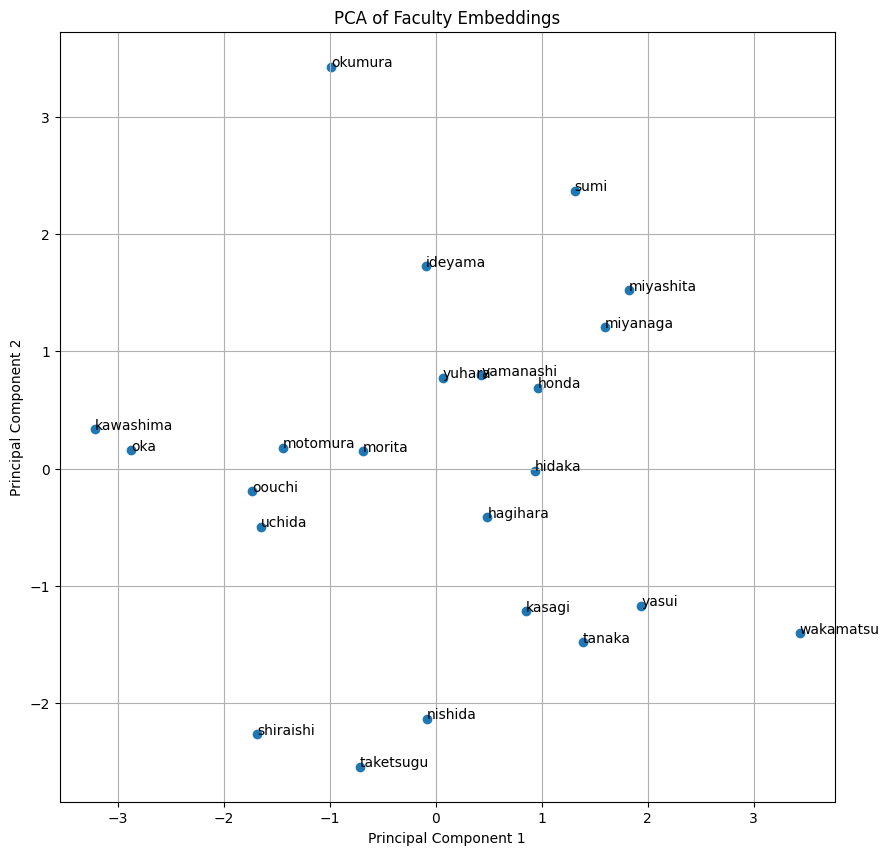

In [ ]:
# prompt: 第1主成分得点を横軸、第2主成分得点を縦軸として可視化。各プロットにfaculty_dfのname列の文字列を付記。

# 第1主成分と第2主成分を抽出
transformed = pca.transform(fa_embeddings)
fa_pc1 = transformed[:, 0]
fa_pc2 = transformed[:, 1]

# 可視化
plt.figure(figsize=(10, 10))
plt.scatter(fa_pc1, fa_pc2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Faculty Embeddings')

# 各プロットに教員名を表示
for i, name in enumerate(faculty_df['name']):
    plt.annotate(name, (fa_pc1[i], fa_pc2[i]))

plt.grid()
plt.show()


第2主成分迄の累積寄与率が28%程度しかないので、第3、第4主成分でも散布図を書いてみる。

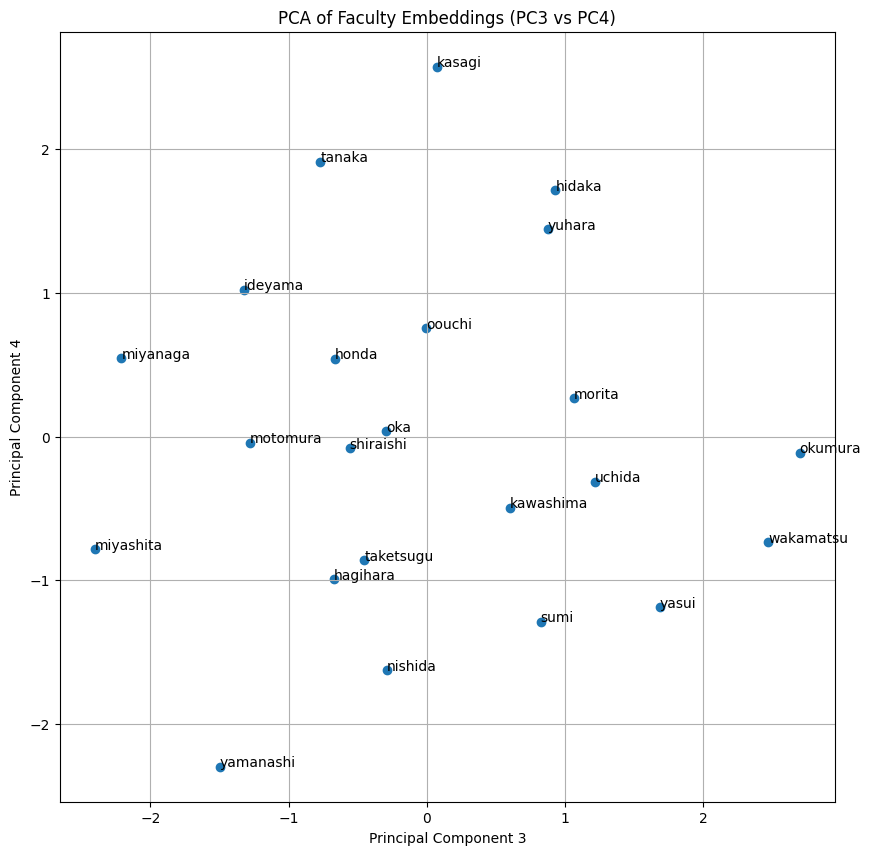

In [ ]:
# prompt: 第3主成分得点を横軸、第4主成分得点を縦軸として同様に可視化

# 第3主成分と第4主成分を抽出
fa_pc3 = transformed[:, 2]
fa_pc4 = transformed[:, 3]

# 可視化
plt.figure(figsize=(10, 10))
plt.scatter(fa_pc3, fa_pc4)
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.title('PCA of Faculty Embeddings (PC3 vs PC4)')

# 各プロットに教員名を表示
for i, name in enumerate(faculty_df['name']):
    plt.annotate(name, (fa_pc3[i], fa_pc4[i]))

plt.grid()
plt.show()


## K-meansクラスタリング（参考）
本当はコサイン類度でクラスタリングすべきだが、ユークリッド距離でクラスタリング

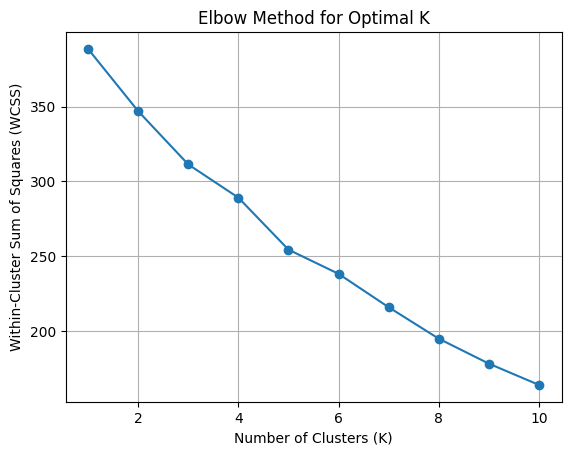

In [ ]:
# prompt: K-meansクラスタリングを異なるクラスタ数 K で実行し、横軸にクラスタ数、縦軸にK-meansの目的関数の値、すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画

from sklearn.cluster import KMeans

# Kの範囲を設定
k_values = range(1, 11)  # 例として1から10までのクラスタ数を試す

wcss_values = []

# 各KについてK-meansを実行し、WCSSを記録
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(fa_embeddings)
    wcss_values.append(kmeans.inertia_)  # WCSSを取得

# WCSSの値をプロット
plt.plot(k_values, wcss_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()


In [ ]:
# prompt: K=5でクラスタリングして、結果を教員名で表示

# K=5でK-meansを実行
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
kmeans.fit(fa_embeddings)

# クラスタのラベルを取得
labels = kmeans.labels_

# クラスタごとに教員名を表示
for cluster_id in range(5):
    print(f"Cluster {cluster_id + 1}:")
    cluster_indices = [i for i, label in enumerate(labels) if label == cluster_id]
    for idx in cluster_indices:
        print(f"  - {faculty_df['name'].iloc[idx]}")
    print()


Cluster 1:
  - yasui
  - wakamatsu

Cluster 2:
  - uchida
  - oka
  - okumura
  - kawashima
  - yuhara
  - oouchi
  - honda
  - motomura
  - morita

Cluster 3:
  - shiraishi
  - taketsugu
  - nishida
  - hagihara

Cluster 4:
  - miyanaga
  - ideyama
  - sumi
  - yamanashi
  - miyashita

Cluster 5:
  - kasagi
  - tanaka
  - hidaka

